In [ ]:
#pip install joypy

In [5]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import multiprocessing as mp
import queue
import shelve
import pandas as pd
import seaborn as sns
from joypy import joyplot

In [15]:
from queue_function import run_queue_experiment, vary_t_worker, vary_rho_worker, expected_waiting_time
from util import initialize_parallel_rngs

In [7]:
mpl.rcParams["figure.dpi"] = 180
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["font.size"] = 12

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"""
     \usepackage{palatino}
     \usepackage{newpxmath}""")
    
plt.rc("font", family="serif")

### Helper functions

In [8]:
from scipy import stats

def sp_confidence_interval(samples, p=0.95):
    """ Calculates the confidence interval (with p=95% unless noted otherwise) 
    Returns:
         Confidence radius (int) based on samples.     
    """
    a = stats.t.interval(p, df=len(samples)-1, loc=np.mean(samples), scale=stats.sem(samples))
    return a[1] - a[0]

In [9]:
def vary_rho(seed, capacity_server, t_length=1e5, n_server=1, steps=20, n_runs=20):
    manager = mp.Manager()
    results = manager.list()
    rhos = np.linspace(0.5, 0.95, steps)
    rngs = initialize_parallel_rngs(mp.cpu_count(), seed)

    work_queue = mp.Queue()
    
    for i in range(n_runs):
        results.append(manager.list())
        for rho in rhos:
            work_queue.put((rho, i))
    
    processes = []
    for i in range(mp.cpu_count()):
        p = mp.Process(target=vary_rho_worker, args=(
            work_queue, results, rngs[i], t_length, capacity_server, n_server
        ))
        p.daemon = True
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    return  [list(t) for t in results], rhos

In [10]:
def vary_t(min_exp, max_exp, seed, arrival_rate, capacity_server, n_server=1, steps=10, n_runs=5,
           queueing_discipline="FIFO"):
    manager = mp.Manager()
    results = manager.list()
    t_range = np.logspace(min_exp, max_exp, num=((max_exp - min_exp) + 1)*steps, dtype=int)
    
    work_queue = mp.Queue()
    for i in range(n_runs):
        results.append(manager.list())
        for t in t_range:
            work_queue.put((t, i))
    
    rngs = initialize_parallel_rngs(mp.cpu_count(), seed)
    processes = []

    for i in range(mp.cpu_count()):
        p = mp.Process(target=vary_t_worker, args=(
            work_queue, results, rngs[i], arrival_rate, capacity_server, n_server, queueing_discipline
        ))
        p.daemon = True
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    return  [list(t) for t in results], t_range

#### Varying t value

In [11]:
if False: 
    shelf = shelve.open("Arrays/t_parameter")
    vary_t_results, t_range = vary_t(min_exp=3, max_exp=6, seed=8539, arrival_rate=0.8, capacity_server=1,
                                    n_runs=50, steps=5)

    shelf["vary_t_results"] = vary_t_results
    shelf["t_range"] = t_range
    shelf.close()

In [12]:
shelf = shelve.open("Arrays/t_parameter")
vary_t_results = shelf["vary_t_results"] 
t_range = shelf["t_range"] 
shelf.close()

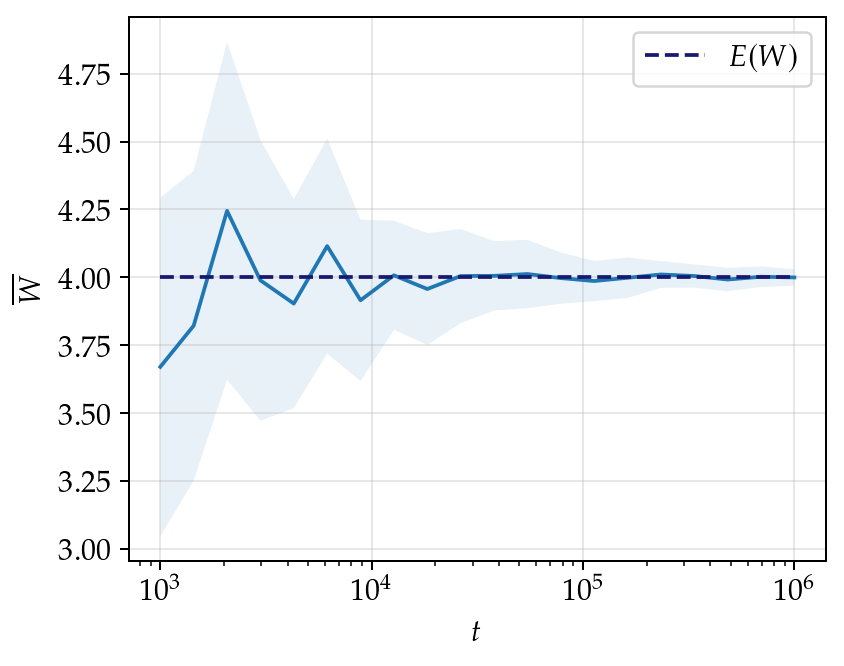

In [52]:
#Make longer and bigger (different rhos)
#And perhaps on a linear scale
fig = plt.figure(figsize=(5, 4))

results = [list(t) for t in vary_t_results]
results_means = np.mean(results, axis=0)
E_W = expected_waiting_time(0.8, 1, 1)
a = [sp_confidence_interval(samples) for samples in np.array(results).T]
plt.plot(t_range, results_means)
plt.fill_between(t_range, results_means - a, results_means + a, alpha=0.1)
plt.hlines(E_W, t_range[0], t_range[-1], label="$E(W)$", color="midnightblue", linestyles="--", zorder=3)
plt.xlabel("$t$")
plt.xscale("log")
plt.ylabel("$\\overline{W}$")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### Varying rho values

In [31]:
if False:
    shelf = shelve.open("Arrays/rho_parameter")
    varying_rho_data = []
    rhos = None

    for i, n_server in enumerate((1, 2, 4)):
        run_data, rhos_ = vary_rho(seed=2378392, capacity_server=1, t_length=1e5, n_runs=50, n_server=n_server, steps = 50)
        #run_data, rhos_ = vary_rho(seed=2378392, capacity_server=1, t_length=1e2, n_runs=50, n_server=n_server, steps = 50)
        rhos = rhos_
        varying_rho_data.append(run_data)

    shelf["vary_rho_results"] = varying_rho_data
    shelf["rhos"] = rhos
    shelf.close()

In [32]:
shelf = shelve.open("Arrays/rho_parameter")
varying_rho_data = shelf["vary_rho_results"]
rhos = shelf["rhos"] 
shelf.close()

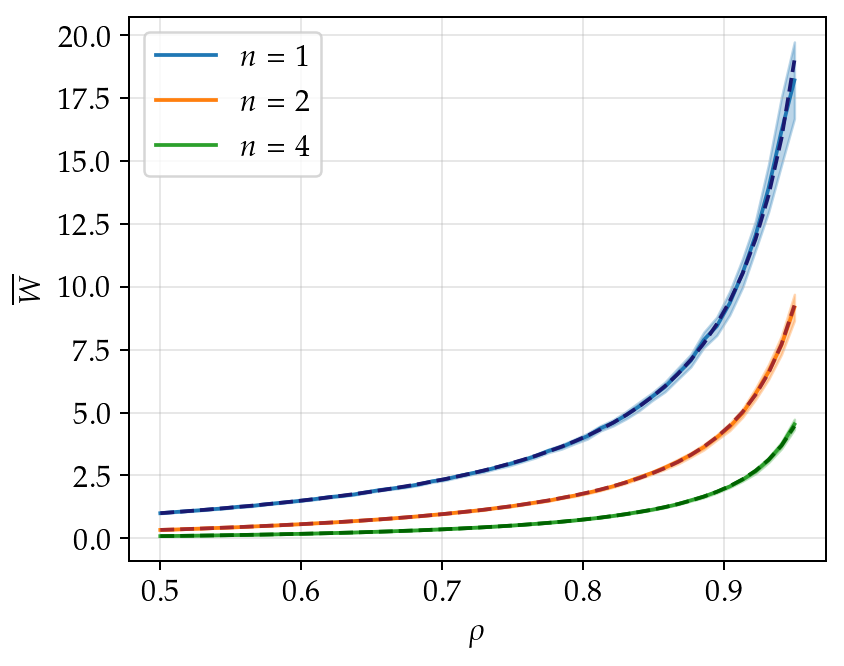

In [108]:
#Start at a later point
fig = plt.figure(figsize=(5, 4))

labels = ("$n = 1$", "$n = 2$", "$n = 4$")
colors = ("tab:blue", "tab:orange", "tab:green")
E_W_colors = ("midnightblue", "brown", "darkgreen")

for i, n_server in enumerate((1, 2, 4)):
    run_data = varying_rho_data[i]
    run_data_mean = np.mean(run_data, axis=0)
    a = [sp_confidence_interval(samples) for samples in np.array(run_data).T]
    run_data_std = np.std(run_data, axis=0, ddof=1)
    plt.plot(rhos, run_data_mean, label=labels[i], color=colors[i])
    plt.fill_between(rhos, run_data_mean - a, run_data_mean + a, alpha=0.3, color=colors[i])
    
    E_Ws = [expected_waiting_time(rho*n_server, 1, n_server) for rho in rhos]
    plt.plot(rhos, E_Ws, "--", color=E_W_colors[i])
    #plt.yscale("log")
    plt.grid(alpha=0.3)

plt.xlabel("$\\rho$")
plt.ylabel("$\\overline{W}$")
plt.legend()
plt.show()

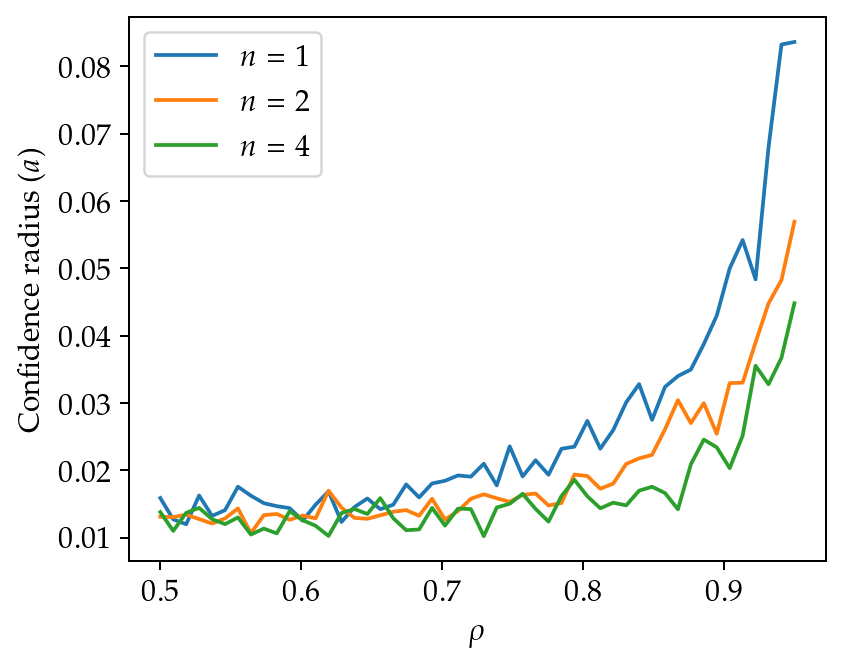

In [115]:
fig = plt.figure(figsize=(5, 4))

for i, n_server in enumerate((1, 2, 4)):
    run_data = varying_rho_data[i]
    a = [sp_confidence_interval(samples) for samples in np.array(run_data).T]
    plt.plot(rhos, a/np.mean(run_data, axis=0), label=labels[i], color=colors[i])

plt.xlabel("$\\rho$")
plt.ylabel("Confidence radius ($a$)")
plt.legend()
plt.show()

#### Comparing M/M/1 and M/M/n

In [65]:
if False:
    shelf = shelve.open("Arrays/stats_varying_n")

    stats_data_n1, _ = vary_t(min_exp=5, max_exp=5, seed=2342342, n_server=1,
                              arrival_rate=0.8*1, capacity_server=1, steps=1, n_runs=500)
    shelf["stats_data_n1"] = sum(stats_data_n1, [])
    stats_data_n2, _ = vary_t(min_exp=5, max_exp=5, seed=3298531, n_server=2,
                              arrival_rate=0.8*2, capacity_server=1, steps=1, n_runs=500)
    shelf["stats_data_n2"] = sum(stats_data_n2, [])
    stats_data_n4, t_range = vary_t(min_exp=5, max_exp=5, seed=1236894, n_server=4,
                                    arrival_rate=0.8*4, capacity_server=1, steps=1, n_runs=500)
    shelf["stats_data_n4"] = sum(stats_data_n4, [])
    
    shelf["t_range"] = t_range
    shelf.close()
    
if False:
    shelf = shelve.open("Arrays/stats_varying_n")

    stats_data_n1, _ = vary_t(min_exp=5, max_exp=5, seed=89253, n_server=1,
                              arrival_rate=0.5*1, capacity_server=1, steps=1, n_runs=500)
    shelf["stats_data_n1_0.5"] = sum(stats_data_n1, [])
    stats_data_n2, _ = vary_t(min_exp=5, max_exp=5, seed=114352, n_server=2,
                              arrival_rate=0.5*2, capacity_server=1, steps=1, n_runs=500)
    shelf["stats_data_n2_0.5"] = sum(stats_data_n2, [])
    stats_data_n4, t_range = vary_t(min_exp=5, max_exp=5, seed=755745, n_server=4,
                                    arrival_rate=0.5*4, capacity_server=1, steps=1, n_runs=500)
    shelf["stats_data_n4_0.5"] = sum(stats_data_n4, [])
    
    shelf["t_range"] = t_range
    shelf.close()
    
if False:
    shelf = shelve.open("Arrays/stats_varying_n")

    stats_data_n1, _ = vary_t(min_exp=5, max_exp=5, seed=89253, n_server=1,
                              arrival_rate=0.95*1, capacity_server=1, steps=1, n_runs=500)
    shelf["stats_data_n1_0.95"] = sum(stats_data_n1, [])
    stats_data_n2, _ = vary_t(min_exp=5, max_exp=5, seed=11010135, n_server=2,
                              arrival_rate=0.95*2, capacity_server=1, steps=1, n_runs=500)
    shelf["stats_data_n2_0.95"] = sum(stats_data_n2, [])
    stats_data_n4, t_range = vary_t(min_exp=5, max_exp=5, seed=885302, n_server=4,
                                    arrival_rate=0.95*4, capacity_server=1, steps=1, n_runs=500)
    shelf["stats_data_n4_0.95"] = sum(stats_data_n4, [])
    
    shelf["t_range"] = t_range
    shelf.close()

In [66]:
shelf = shelve.open("Arrays/stats_varying_n")

stats_data = []

for rho in ("0.5", "", "0.95"):
    key = f"_{rho}" if rho != "" else ""
    stats_data_n1 = shelf[f"stats_data_n1{key}"]
    stats_data_n2 = shelf[f"stats_data_n2{key}"]
    stats_data_n4 = shelf[f"stats_data_n4{key}"]
    stats_data.append((stats_data_n1, stats_data_n2, stats_data_n4))

t_range = shelf["t_range"] 
shelf.close()

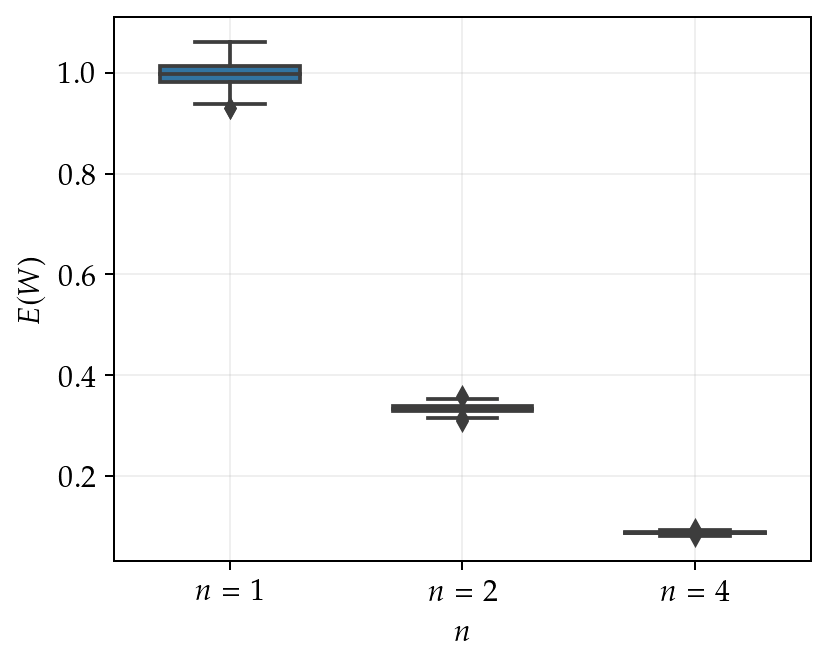

In [116]:
fig = plt.figure(figsize=(5, 4))

stats_data_n1, stats_data_n2, stats_data_n4 = stats_data[0] # index 0 = 0.5, index 1 = 0.8, index 2 = 0.95

values_n1 = np.array(stats_data_n1)
values_n2 = np.array(stats_data_n2)
values_n4 = np.array(stats_data_n4)
data_n1 = np.array([np.repeat("$n = 1$", len(values_n1)), values_n1])
data_n2 = np.array([np.repeat("$n = 2$", len(values_n2)), values_n2])
data_n3 = np.array([np.repeat("$n = 4$", len(values_n4)), values_n4])
Data = np.concatenate([data_n1, data_n2, data_n3], axis = 1)

df = pd.DataFrame(Data.T, columns = ["n", "E(W)"])
df = df.astype({"E(W)": float})
ax = sns.boxplot(x="n", y="E(W)",  data=df, width = 0.6, zorder=3)
ax.set_axisbelow(True)
plt.grid(alpha = 0.2, zorder=0)
#plt.yscale("log")
plt.ylabel("$E(W$)")
plt.xlabel("$n$")
plt.show()

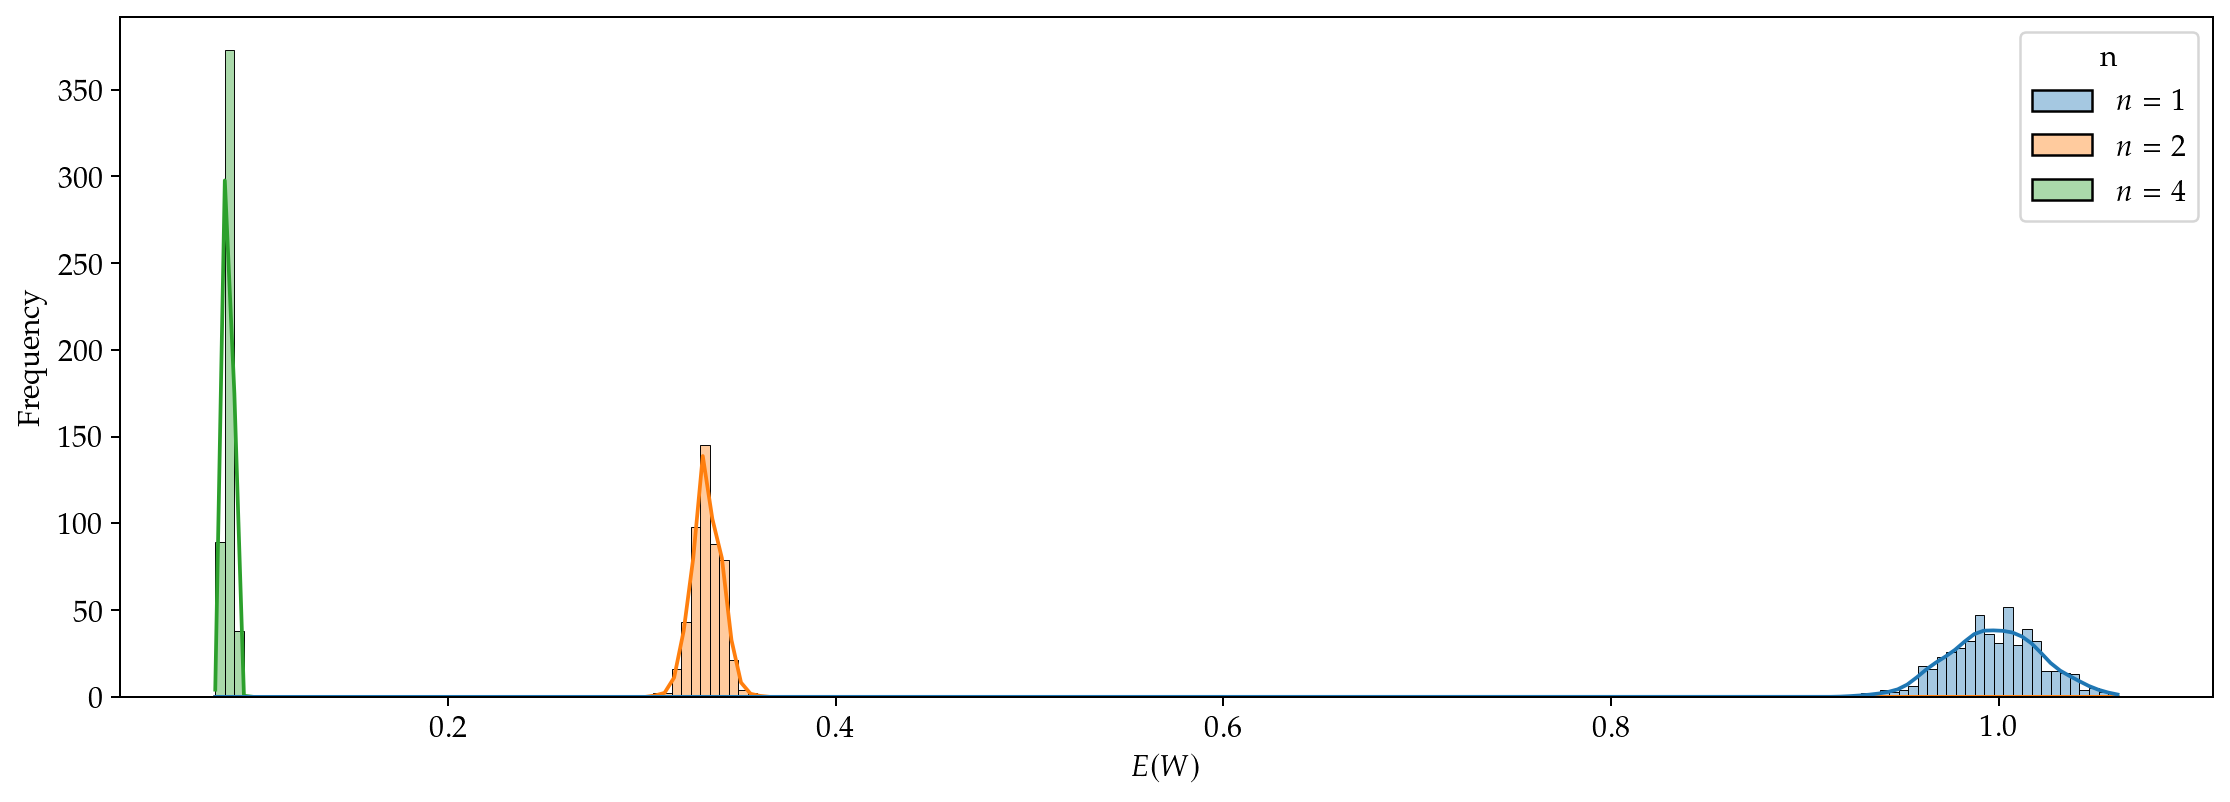

In [117]:
plt.figure(figsize = (15,5))
sns.histplot(data = df, hue="n", x="E(W)", alpha=0.4, kde = True, bins = 200)
plt.xlabel("$E(W)$")
plt.ylabel("Frequency")
plt.show()

<Figure size 1080x720 with 0 Axes>

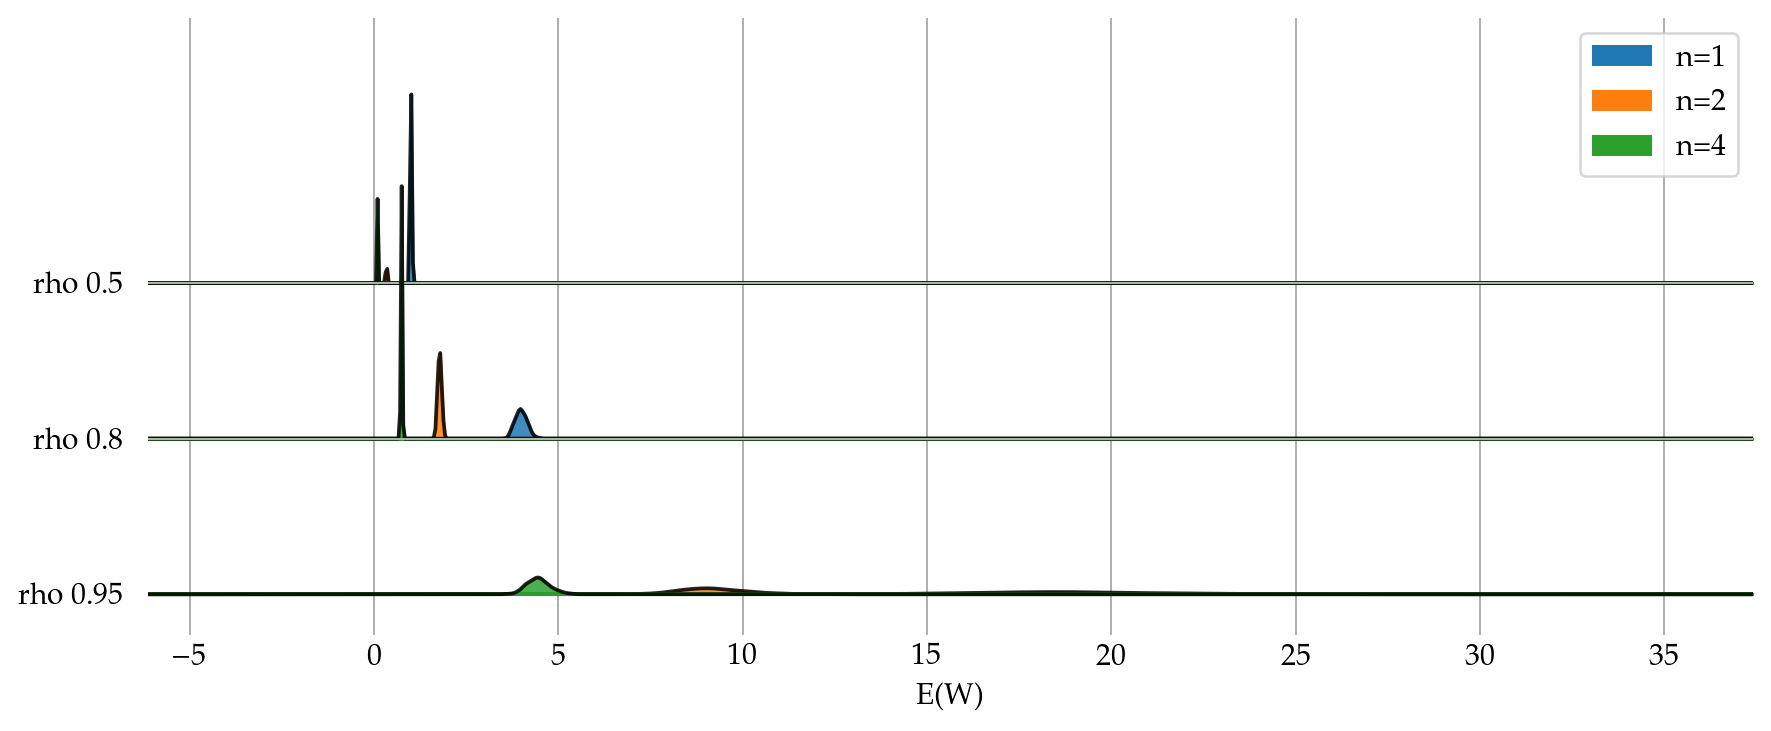

In [118]:
values_n1 = np.array(stats_data_n1)
values_n2 = np.array(stats_data_n2)
values_n4 = np.array(stats_data_n4)
data_rho_1 = np.array([np.repeat("rho 0.8", len(stats_data[1][0])), stats_data[1][0], stats_data[1][1], stats_data[1][2]])
data_rho_2 = np.array([np.repeat("rho 0.5", len(stats_data[0][0])), stats_data[0][0], stats_data[0][1], stats_data[0][2]])
data_rho_3 = np.array([np.repeat("rho 0.95",  len(stats_data[2][0])), stats_data[2][0], stats_data[2][1], stats_data[2][2]])
Data = np.concatenate([data_rho_1, data_rho_2, data_rho_3], axis = 1)

df = pd.DataFrame(Data.T, columns = ["rho", "n=1", "n=2", "n=4" ])
df = df.astype({"n=1": float})
df = df.astype({"n=2": float})
df = df.astype({"n=4": float})
#display(df)

plt.figure()
ax, fig = joyplot(
    data=df[['rho', 'n=1', 'n=2', 'n=4']], 
    by='rho',
    column=['n=1', 'n=2', 'n=4'],
    color=["tab:blue", "tab:orange", "tab:green"],
    legend=True,
    alpha=0.85,
    #overlap=3,
    figsize=(10, 4),
    #hist=True,
    #bins = 200,
    grid=True,
)
plt.xlabel('E(W)', fontsize=12)
plt.show()

#### Comparing FIFO and SPTF

In [119]:
if False:
    shelf = shelve.open("Arrays/stats_sptf_fifo")

    sptf_stats = sum(vary_t(min_exp=5, max_exp=5, seed=91102, n_server=1, n_runs=500,
                   arrival_rate=0.8, capacity_server=1, steps=1, queueing_discipline="SPTF")[0], [])
    shelf["sptf_stats"] = sptf_stats
    shelf.close()
    


In [120]:
shelf = shelve.open("Arrays/stats_sptf_fifo")
sptf_stats = shelf["sptf_stats"] 
shelf.close()

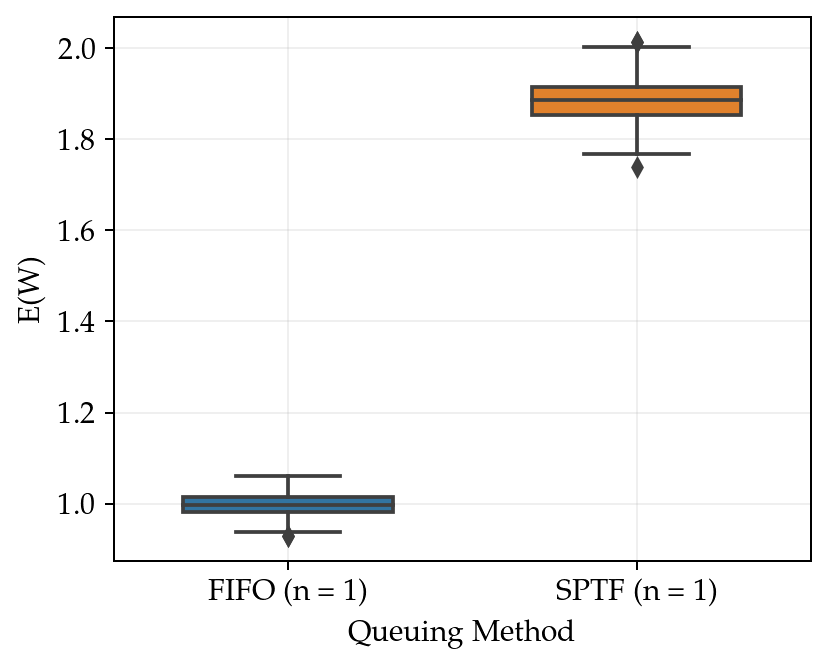

In [123]:
plt.figure(figsize = (5, 4))
values_fifo = np.array(stats_data_n1)
values_sptf = np.array(sptf_stats)
data_fifo = np.array([np.repeat("FIFO (n = 1)", len(values_fifo)), values_fifo])
data_sptf = np.array([np.repeat("SPTF (n = 1)", len(values_sptf)), values_sptf])
data_fifo_sptf = np.concatenate([data_fifo, data_sptf], axis = 1)

df_fifo_sptf = pd.DataFrame(data_fifo_sptf.T, columns = ["Queueing Method", "E(W)"])
df_fifo_sptf = df_fifo_sptf.astype({"E(W)": float})
ax = sns.boxplot(x="Queueing Method", y="E(W)",  data=df_fifo_sptf, width = 0.6, zorder=3)
ax.set_axisbelow(True)
plt.grid(alpha = 0.2, zorder=0)
#plt.title(f"rho = {rho}")
#plt.yscale("log")
plt.ylabel("E(W)")
plt.xlabel("Queuing Method")
plt.show()

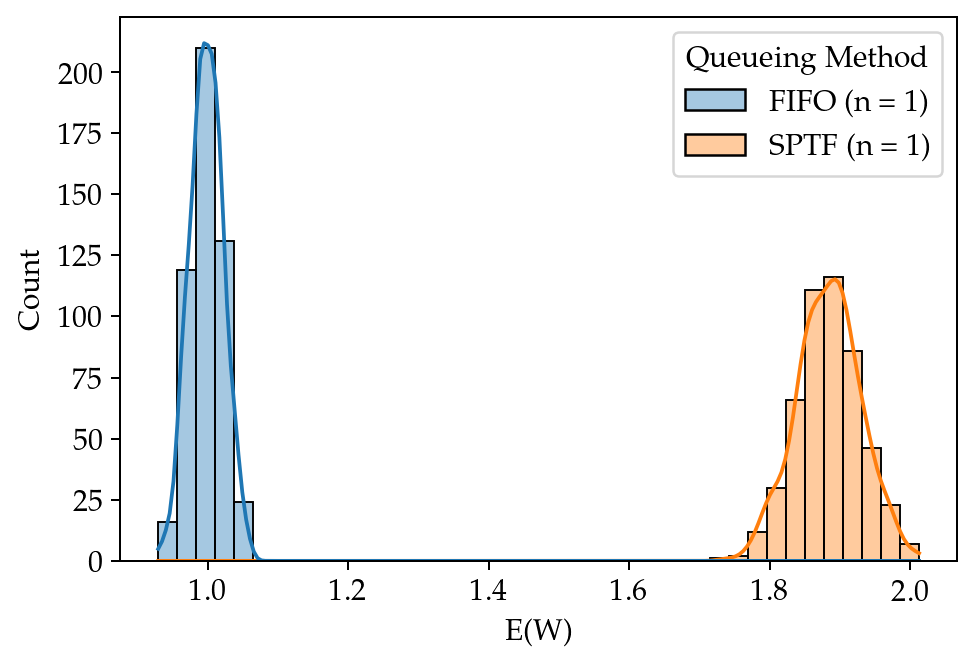

In [122]:
sns.histplot(data = df_fifo_sptf, hue="Queueing Method", x="E(W)", alpha=0.4, kde = True, bins=40)
plt.show()